In [14]:
import pandas as pd
import os, sys
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from utils.prediction_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

import xgboost as xgb

random_seed = 42

In [15]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X_orig, y_orig = get_data("conv2d", base_dir, sample_rate=1.0)
X_orig.info()

34it [00:20,  1.09it/s]

< 0 found in file time.32.1024.0.pkl


44it [00:29,  1.03s/it]

< 0 found in file time.128.512.0.pkl


46it [00:32,  1.08s/it]

< 0 found in file time.128.1024.0.pkl


54it [00:39,  1.16it/s]

< 0 found in file time.512.128.0.pkl


56it [00:41,  1.07it/s]

< 0 found in file time.512.512.0.pkl


58it [00:43,  1.04it/s]

< 0 found in file time.512.1024.0.pkl


59it [00:45,  1.17s/it]

< 0 found in file time.512.1024.1.pkl


64it [00:47,  1.43it/s]

< 0 found in file time.1024.32.0.pkl


66it [00:50,  1.23it/s]

< 0 found in file time.1024.128.0.pkl


68it [00:52,  1.13it/s]

< 0 found in file time.1024.512.0.pkl


69it [00:53,  1.10s/it]

< 0 found in file time.1024.512.1.pkl


70it [00:54,  1.06it/s]

< 0 found in file time.1024.1024.0.pkl


71it [00:56,  1.14s/it]

< 0 found in file time.1024.1024.1.pkl


72it [00:56,  1.27it/s]
/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:297: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685125 entries, 0 to 685124
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   b             685125 non-null  int64  
 1   in_channels   685125 non-null  int64  
 2   iH            685125 non-null  int64  
 3   iW            685125 non-null  int64  
 4   out_channels  685125 non-null  int64  
 5   groups        685125 non-null  int64  
 6   kH            685125 non-null  int64  
 7   kW            685125 non-null  int64  
 8   stride        685125 non-null  int64  
 9   dilation      685125 non-null  int64  
 10  gflops        685125 non-null  float64
 11  dtype_16      685125 non-null  bool   
 12  dtype_32      685125 non-null  bool   
 13  dtype_b16     685125 non-null  bool   
 14  transposed_0  685125 non-null  bool   
 15  transposed_1  685125 non-null  bool   
dtypes: bool(5), float64(1), int64(10)
memory usage: 60.8 MB


In [16]:
df = pd.concat([X_orig, y_orig], axis=1)
df = df.query("time > 0").dropna()

In [17]:
df["gflops_per_ms"] = df["gflops"] / df["time"]

padding = 0
output_padding = 0

df["oH"] = np.where(
    df["transposed_1"] == 0,
    (df["iH"] + 0 - df["dilation"] * (df["kH"] - 1) - 1) // df["stride"] + 1,
    (df["iH"] - 1) * df["stride"] - 2 * padding + df["dilation"] * (df["kH"] - 1) + output_padding + 1
)

df["oW"] = np.where(
    df["transposed_1"] == 0,
    (df["iW"] + 0 - df["dilation"] * (df["kW"] - 1) - 1) // df["stride"] + 1,
    (df["iW"] - 1) * df["stride"] - 2 * padding + df["dilation"] * (df["kW"] - 1) + output_padding + 1
)

# Note: this is a heuristic.
input_memory_accesses = df["b"] * df["in_channels"] * df["iH"] * df["iW"]
kernel_memory_accesses = df["out_channels"] * (df["in_channels"] // df["groups"]) * df["kH"] * df["kW"]
output_memory_accesses = df["b"] * df["out_channels"] * df["oH"] * df["oW"]
df["memory_accesses"] = input_memory_accesses + kernel_memory_accesses + output_memory_accesses

df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]

# Hypothetical best

Note: it's interesting that we can't even reconstruct `time` from `gflops_per_ms` and `gflops`...

In [18]:
X, y = df.drop(["time"], axis=1), df["time"]
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 444058 entries, 178626 to 121958
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   b                444058 non-null  int64  
 1   in_channels      444058 non-null  int64  
 2   iH               444058 non-null  int64  
 3   iW               444058 non-null  int64  
 4   out_channels     444058 non-null  int64  
 5   groups           444058 non-null  int64  
 6   kH               444058 non-null  int64  
 7   kW               444058 non-null  int64  
 8   stride           444058 non-null  int64  
 9   dilation         444058 non-null  int64  
 10  gflops           444058 non-null  float64
 11  dtype_16         444058 non-null  bool   
 12  dtype_32         444058 non-null  bool   
 13  dtype_b16        444058 non-null  bool   
 14  transposed_0     444058 non-null  bool   
 15  transposed_1     444058 non-null  bool   
 16  gflops_per_ms    444058 non-null  floa

Train--------
Mean Squared Error: 1024.3959013119972
MAPE: 0.005919019240018191
R-squared: 0.9980152685837641


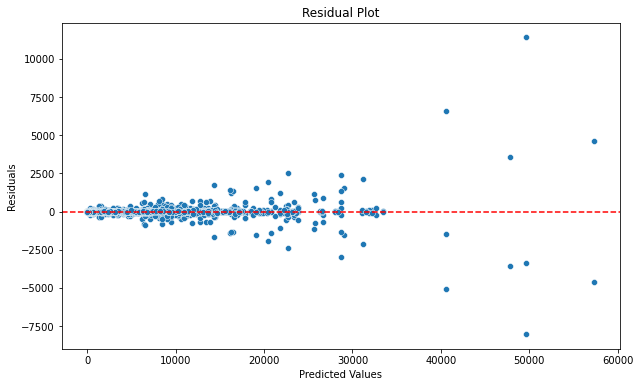

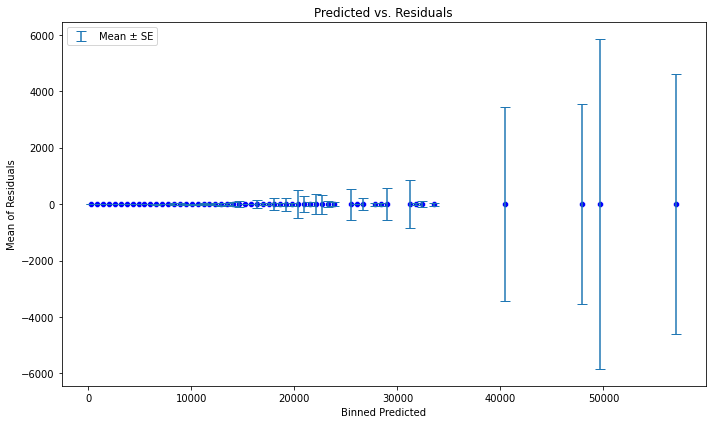

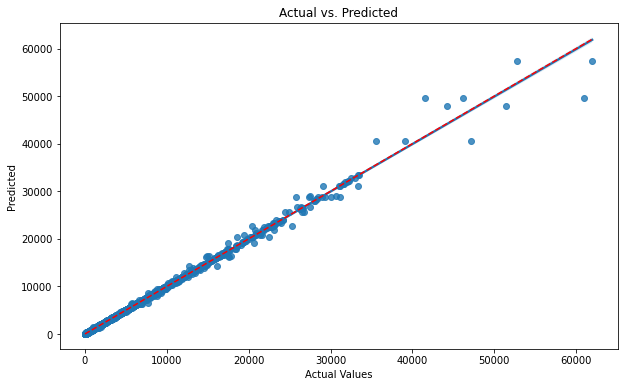

Val--------
Mean Squared Error: 3973.0273478455865
MAPE: 0.020485168705172356
R-squared: 0.9928010737130163


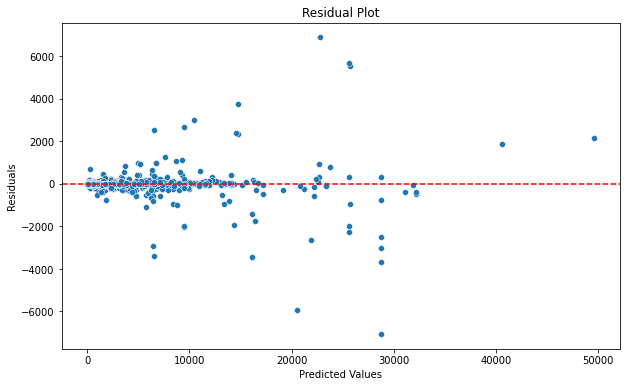

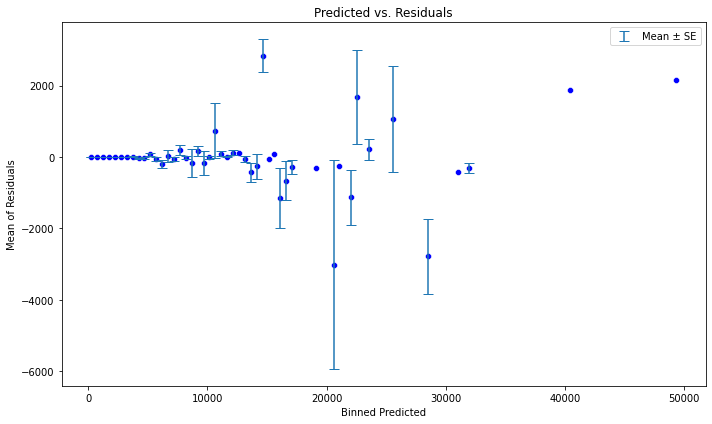

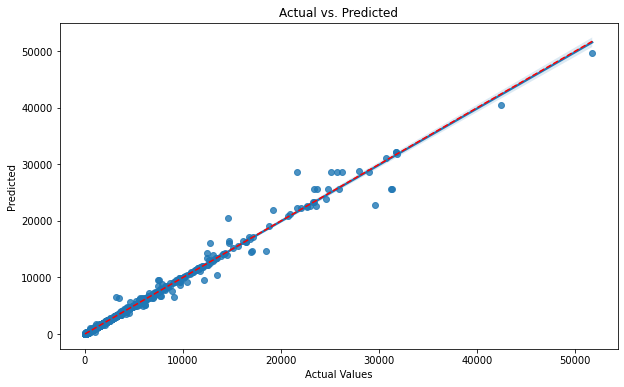

In [19]:
tree_model = DecisionTreeRegressor(max_depth=40, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_train, y_train)
run_val_pipeline(tree_model, X_train, X_val, y_train, y_val)

# Fitting

In [20]:
X, y = df.drop(["time", "gflops_per_ms"], axis=1), df["time"]
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 444058 entries, 178626 to 121958
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   b                444058 non-null  int64  
 1   in_channels      444058 non-null  int64  
 2   iH               444058 non-null  int64  
 3   iW               444058 non-null  int64  
 4   out_channels     444058 non-null  int64  
 5   groups           444058 non-null  int64  
 6   kH               444058 non-null  int64  
 7   kW               444058 non-null  int64  
 8   stride           444058 non-null  int64  
 9   dilation         444058 non-null  int64  
 10  gflops           444058 non-null  float64
 11  dtype_16         444058 non-null  bool   
 12  dtype_32         444058 non-null  bool   
 13  dtype_b16        444058 non-null  bool   
 14  transposed_0     444058 non-null  bool   
 15  transposed_1     444058 non-null  bool   
 16  oH               444058 non-null  int6

## Decision Tree

Takewaway: decision tree struggles for larger values.

Train--------
Mean Squared Error: 5699.095565448002
MAPE: 0.0355313852219337
R-squared: 0.9889582006347465


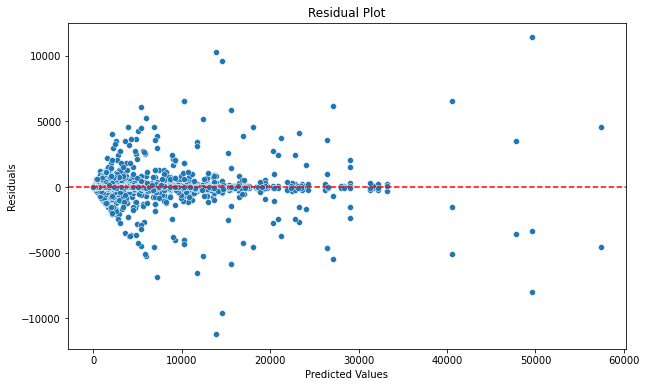

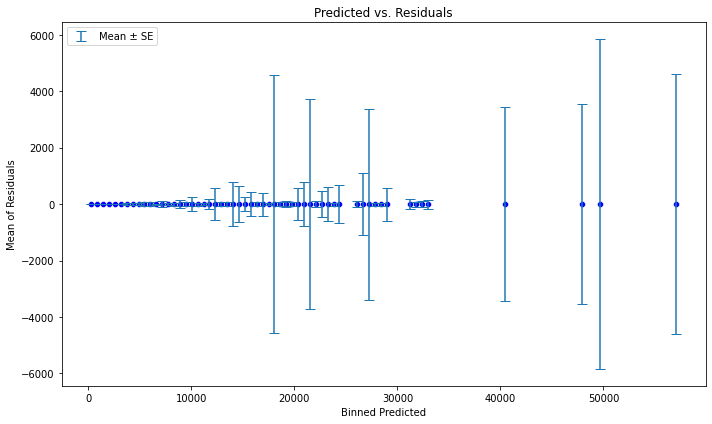

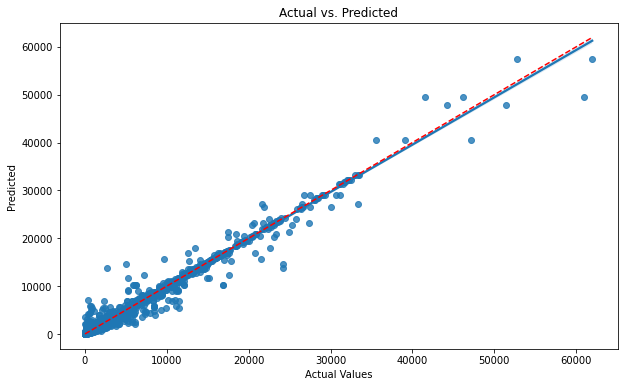

Val--------
Mean Squared Error: 26801.921320191712
MAPE: 0.14143137150346935
R-squared: 0.9514362628190255


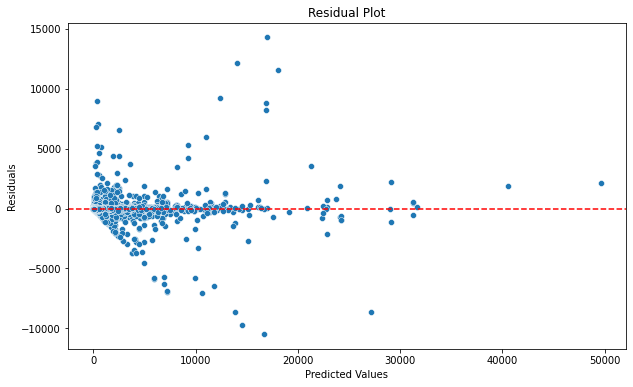

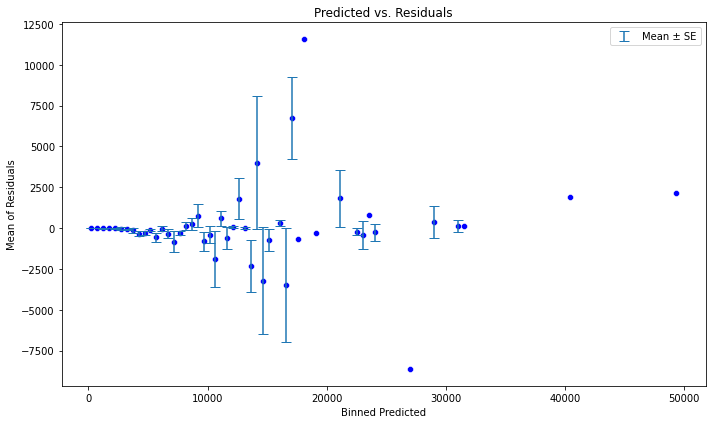

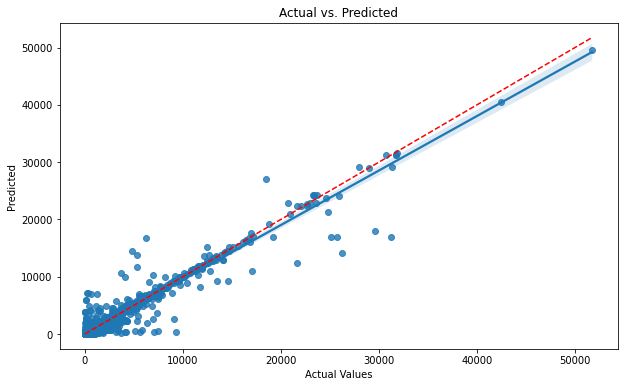

In [21]:
tree_model = DecisionTreeRegressor(max_depth=40, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_train, y_train)
run_val_pipeline(tree_model, X_train, X_val, y_train, y_val)

In [23]:
feature_importances = tree_model.feature_importances_
features_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": feature_importances}
)

features_df = features_df.sort_values(by="Importance", ascending=False)
features_df

,Feature,Importance
10,gflops,0.341755
5,groups,0.315782
12,dtype_32,0.102961
18,memory_accesses,0.090916
0,b,0.030668
15,transposed_1,0.020204
14,transposed_0,0.017090
13,dtype_b16,0.016372
1,in_channels,0.016032
4,out_channels,0.015050


## Random Forest

Train--------
Mean Squared Error: 6535.2702288376295
MAPE: 0.062281838387770176
R-squared: 0.987338141318066


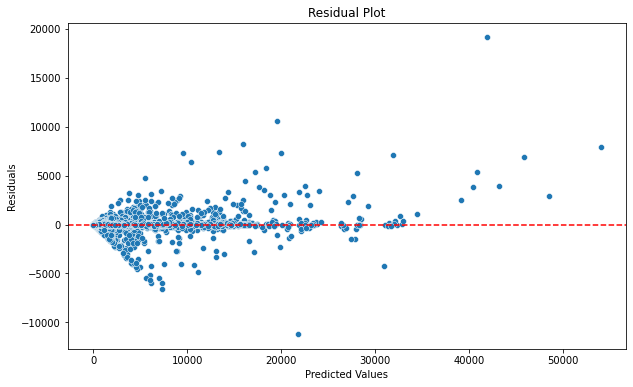

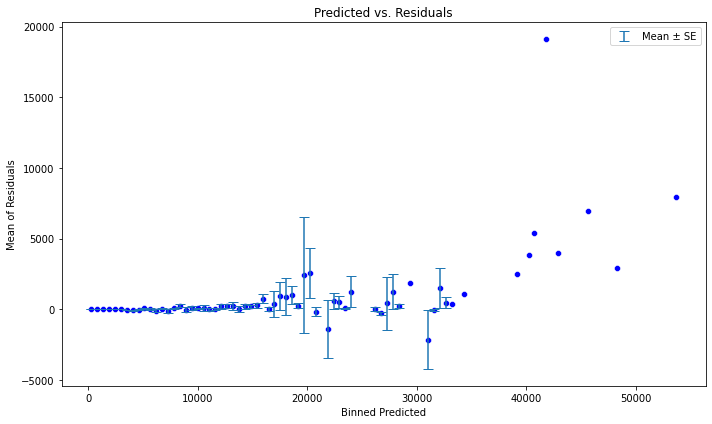

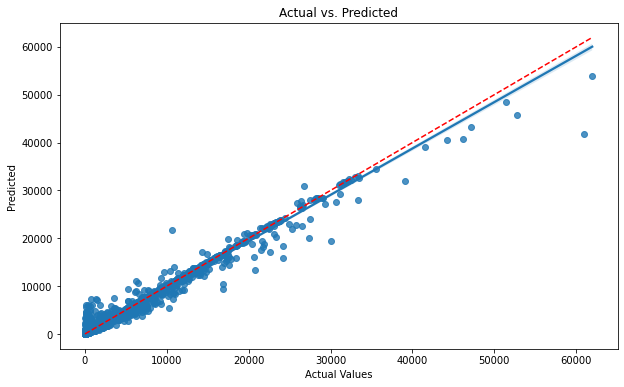

Val--------
Mean Squared Error: 48906.57092604053
MAPE: 0.16550797396232683
R-squared: 0.9113837463926288


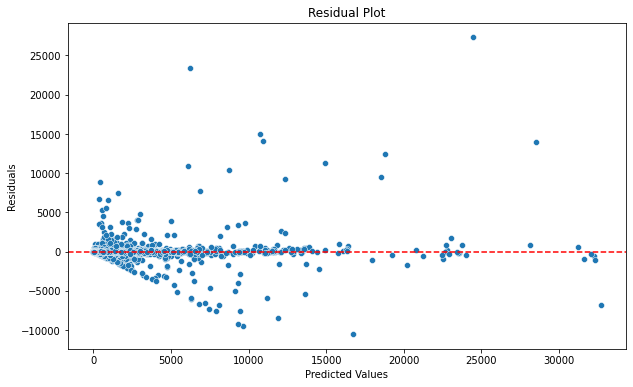

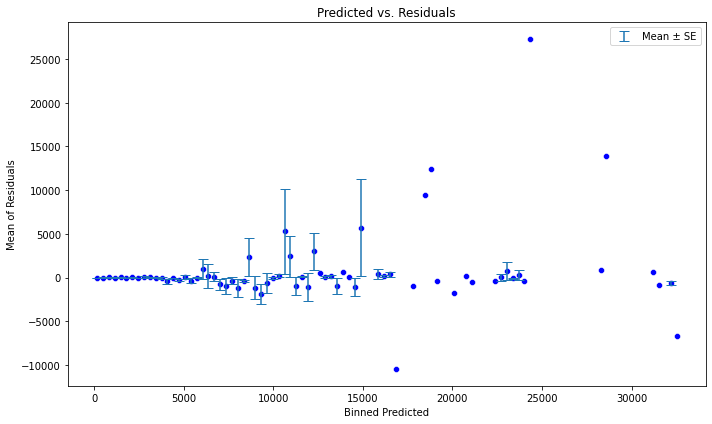

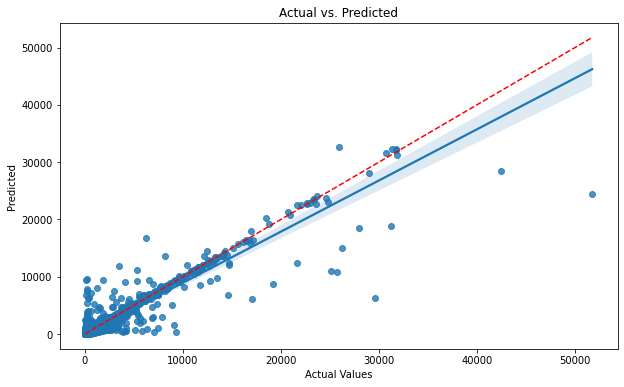

In [33]:
tree_model = RandomForestRegressor(n_estimators=30, max_depth=80, random_state=random_seed)
tree_model.fit(X_train, y_train)
run_val_pipeline(tree_model, X_train, X_val, y_train, y_val)

In [30]:
feature_importances = tree_model.feature_importances_
features_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": feature_importances}
)

features_df = features_df.sort_values(by="Importance", ascending=False)
features_df

,Feature,Importance
10,gflops,0.328486
5,groups,0.312612
12,dtype_32,0.096885
18,memory_accesses,0.085599
19,intensity,0.030890
0,b,0.020659
1,in_channels,0.020137
11,dtype_16,0.019235
14,transposed_0,0.019065
15,transposed_1,0.016520


# Large value that doesn't get fit well?

In [32]:
df.query("time > 50000").describe()

,b,in_channels,iH,iW,out_channels,groups,kH,kW,stride,dilation,gflops,time,gflops_per_ms,oH,oW,memory_accesses,intensity
count,5.0,5.000000,5.000000,5.0,5.000000,5.000000,5.00000,5.00000,5.0,5.0,5.000000e+00,5.000000,5.000000,5.00000,5.000000,5.000000e+00,5.000000
mean,32.0,2457.600000,460.800000,640.0,2457.600000,819.200000,5.40000,4.60000,1.0,1.0,1.329969e+06,55772.092187,24.077438,465.20000,643.600000,2.608799e+10,50925.495172
std,0.0,841.301848,368.764423,384.0,841.301848,280.433949,2.19089,2.19089,0.0,0.0,4.552839e+05,5249.693467,8.732365,369.53376,384.672328,1.787052e+08,17275.371838
min,32.0,1536.000000,128.000000,128.0,1536.000000,512.000000,3.00000,3.00000,1.0,1.0,8.312308e+05,51369.460938,13.624159,130.00000,130.000000,2.597182e+10,32005.107378
25%,32.0,1536.000000,128.000000,512.0,1536.000000,512.000000,3.00000,3.00000,1.0,1.0,8.312308e+05,51759.998047,16.059328,134.00000,514.000000,2.597182e+10,32005.107378
50%,32.0,3072.000000,512.000000,512.0,3072.000000,1024.000000,7.00000,3.00000,1.0,1.0,1.662462e+06,52762.773438,26.832636,514.00000,518.000000,2.604800e+10,62971.260197
75%,32.0,3072.000000,512.000000,1024.0,3072.000000,1024.000000,7.00000,7.00000,1.0,1.0,1.662462e+06,61011.529297,31.508230,518.00000,1026.000000,2.604800e+10,63823.000455
max,32.0,3072.000000,1024.000000,1024.0,3072.000000,1024.000000,7.00000,7.00000,1.0,1.0,1.662462e+06,61956.699219,32.362839,1030.00000,1030.000000,2.640032e+10,63823.000455
